In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler

In [7]:
a_df = pd.read_csv("idosorok/A.csv")
b_df = pd.read_csv("idosorok/B.csv")
c_df = pd.read_csv("idosorok/C.csv")
a_df = a_df[11520:].reset_index(drop=True)
c_df = c_df[1440:].reset_index(drop=True)
a_df["timestamp"] = pd.to_datetime(a_df["timestamp"])
b_df["timestamp"] = pd.to_datetime(b_df["timestamp"])
c_df["timestamp"] = pd.to_datetime(c_df["timestamp"])

In [3]:
a_df = pd.read_csv("idosorok/A.csv")
b_df = pd.read_csv("idosorok/B.csv")
c_df = pd.read_csv("idosorok/C.csv")

In [3]:
a_df.to_csv("idosorok/labeling/a_actual.csv", index=None)
b_df.to_csv("idosorok/labeling/b_actual.csv", index=None)
c_df.to_csv("idosorok/labeling/c_actual.csv", index=None)

In [8]:
class Node:
    def __init__(self, left=None, right=None, counter=0, next_model_counter=0, split_attrib=0, split_value=0.0, depth=0):
        self.left = left
        self.right = right
        self.counter = counter
        self.next_model_counter = next_model_counter
        self.split_attrib = split_attrib
        self.split_value = split_value
        self.k = depth


def generate_max_min(dimensions):
    max_arr = np.zeros((dimensions))
    min_arr = np.zeros((dimensions))
    for q in range(dimensions):
        s_q = np.random.random_sample()
        max_value = max(s_q, 1 - s_q)
        max_arr[q] = s_q + 2 * max_value
        min_arr[q] = s_q - 2 * max_value
    return max_arr, min_arr


def BuildSingleHSTree(max_arr, min_arr, current_depth, depth, num_dimensions):
    if current_depth == depth:
        return Node(depth=current_depth)
    node = Node()
    choosen_dim = np.random.randint(num_dimensions)
    split_threshold = (max_arr[choosen_dim] + min_arr[choosen_dim]) / 2.0
    temp = max_arr[choosen_dim]
    max_arr[choosen_dim] = split_threshold
    node.left = BuildSingleHSTree(max_arr, min_arr, current_depth + 1, depth, num_dimensions)
    max_arr[choosen_dim] = temp
    min_arr[choosen_dim] = split_threshold
    node.right = BuildSingleHSTree(max_arr, min_arr, current_depth + 1, depth, num_dimensions)
    node.split_attrib = choosen_dim
    node.split_value = split_threshold
    node.k = current_depth
    return node


def UpdateMass(x, node):
    if (node):
        if (node.k != 0):
            node.counter += 1
        if (x[node.split_attrib] > node.split_value):
            node_new = node.right
        else:
            node_new = node.left
        UpdateMass(x, node_new)


def UpdateMassNextModel(x, node):
    if (node):
        if (node.k != 0):
            node.next_model_counter += 1
        if (x[node.split_attrib] > node.split_value):
            node_new = node.right
        else:
            node_new = node.left
        UpdateMassNextModel(x, node_new)


def ScoreTree(x, node):
    if (not node):
        return 0
    if (x[node.split_attrib] > node.split_value):
        node_new = node.right
    else:
        node_new = node.left
    return node.counter * (2 ** node.k) + ScoreTree(x, node_new)


def ScoreTreeAlt(x, node):
    current_node = node
    while current_node.right and current_node.left:
        if (x[current_node.split_attrib] > current_node.split_value):
            current_node = current_node.right
        else:
            current_node = current_node.left
    return current_node.counter


def UpdateModel(node, weight_old=0.0, weight_new=1.0):
    if (node):
        node.counter = node.counter * weight_old + node.next_model_counter * weight_new
        node.next_model_counter = 0
        UpdateModel(node.left, weight_old, weight_new)
        UpdateModel(node.right, weight_old, weight_new)


def BuildTrees(num_dimensions, num_trees, depth):
    HSTree_list = []
    for i in range(num_trees):
        max_arr, min_arr = generate_max_min(num_dimensions)
        HSTree_list.append(BuildSingleHSTree(max_arr, min_arr, 0, depth, num_dimensions))
    return HSTree_list


def GenerateFeaturesFirstWeek(df):
    pd.options.mode.chained_assignment = None
    d = df.copy().reset_index(drop=True)
    d["diff"] = d["value"].diff()
    d["diff"][0] = 0
    d["hour"] = d["timestamp"].dt.hour
    d["day"] = d["timestamp"].dt.dayofweek
    d["diff_from_mean"] = d["value"] - d["value"].rolling(60).mean()
    d["diff_from_mean"][:59] = d["diff_from_mean"][59]
    d["diff_diff_from_diff_mean"] = d["diff"] - d["diff"].rolling(60).mean()
    d["diff_diff_from_diff_mean"][:59] = d["diff_diff_from_diff_mean"][59]
    d.drop(columns="timestamp", axis=0, inplace=True)

    days = []
    for i in range(7):
        days.append(d["value"].values[i * 1440: (i + 1) * 1440])

    d["relative_diff"] = 0
    range_min = sum([day.min() for day in days]) / 7.0
    range_max = sum([day.max() for day in days]) / 7.0
    for i in range(7):
        avg_day = np.average(np.vstack(days + [days[i]]), axis=0)
        d["relative_diff"][i * 1440: (i + 1) * 1440] = (d["value"][i * 1440: (i + 1) * 1440] - avg_day) / avg_day

    d_unscaled = d.copy()
    # min max scaling
    for colname in ["value", "diff_from_mean", "relative_diff", "day", "diff", "diff_diff_from_diff_mean"]:
        colmin = d[colname].min()
        colrange = d[colname].max() - colmin
        d[colname] = (d[colname] - colmin) / colrange
    d["hour"] = d["hour"] / 23.0

    pd.options.mode.chained_assignment = "warn"
    return d, d_unscaled


def DetectTimeSeries(full_df):
    pd.options.mode.chained_assignment = None
    df = full_df.copy().reset_index(drop=True)
    first_week, first_week_raw = GenerateFeaturesFirstWeek(df[:1440 * 7])
    trees = BuildTrees(first_week.shape[1], 60, 12)
    first_week_data = first_week.values
    for sample in range(1440 * 7):
        for tree in trees:
            UpdateMass(first_week_data[sample], tree)
    score_results = np.zeros((df.shape[0] // 1440 * 1440))
#     for sample in range(1440 * 7):
#         s = 0
#         for tree in trees:
#             s += ScoreTree(first_week_data[sample], tree)
#         score_results[sample] = s
    print("Model initialized")

    past_week = first_week
    past_week_raw = first_week_raw
    # now we first score the next week, then update the model
    # for performance, we first transform a whole day of data
    # but notice, that this process contains no lookahead bias (unlike the algorithms needing exact max, min)
    # also for performance
    df["diff"] = df["value"].diff()
    df["hour"] = df["timestamp"].dt.hour / 23.0
    df["day"] = df["timestamp"].dt.dayofweek / 6.0
    df["diff_from_mean"] = df["value"] - df["value"].rolling(60).mean()
    df["diff_diff_from_diff_mean"] = df["diff"] - df["diff"].rolling(60).mean()
    start = 1440 * 7
    while start + 1440 <= full_df.shape[0]:
        current_day = pd.DataFrame()
        for colname in ["value", "diff_from_mean", "day", "hour", "diff", "diff_diff_from_diff_mean"]:
            current_day[colname] = df[colname].values[start: start + 1440]
        value_days = [df["value"][start - 1440 * 7 + i * 1440: start - 1440 * 7 + (i + 1) * 1440] for i in range(7)]
        range_min = sum([day.min() for day in value_days]) / 7.0
        range_max = sum([day.max() for day in value_days]) / 7.0
        decile = (range_max - range_min) / 10.0
        avg_day = np.average(np.vstack(value_days + [value_days[0]]), axis=0)
        current_day["relative_diff"] = (current_day["value"] - avg_day) / avg_day
        # we need the raw values for the normalization
        # hour and day are already normalized, but they will not be queried from past_week_raw anyway
        past_week_raw = pd.concat([past_week_raw, current_day])[1440:].reset_index(drop=True)
        raw_days = [past_week_raw[i * 1440: (i + 1) * 1440] for i in range(7)]
        for colname in ["value", "relative_diff", "diff_from_mean", "diff", "diff_diff_from_diff_mean"]:
            colmin = sum([raw_day[colname].min() for raw_day in raw_days]) / 7.0
            colmax = sum([raw_day[colname].max() for raw_day in raw_days]) / 7.0
            current_day[colname] = (current_day[colname] - colmin) / (colmax - colmin)

        X = current_day.values
        for minute in range(1440):
            s = 0
            for tree in trees:
                s += ScoreTree(X[minute], tree)
                UpdateMassNextModel(X[minute], tree)
            score_results[start + minute] = s

        past_week = pd.concat([past_week, current_day])[1440:].reset_index(drop=True)
        first_week = pd.concat([first_week, current_day])

        start += 1440
        for tree in trees:
            UpdateModel(tree, weight_old=10.0/11.0, weight_new=7.0*1/11.0)
        print("Finished a day,", start, "points done, model updated")

    pd.options.mode.chained_assignment = "warn"
    return score_results, first_week

In [9]:
df_to_use = b_df
scores, dataset = DetectTimeSeries(df_to_use)

Model initialized
Finished a day, 11520 points done, model updated
Finished a day, 12960 points done, model updated
Finished a day, 14400 points done, model updated
Finished a day, 15840 points done, model updated
Finished a day, 17280 points done, model updated
Finished a day, 18720 points done, model updated
Finished a day, 20160 points done, model updated
Finished a day, 21600 points done, model updated
Finished a day, 23040 points done, model updated
Finished a day, 24480 points done, model updated
Finished a day, 25920 points done, model updated
Finished a day, 27360 points done, model updated
Finished a day, 28800 points done, model updated
Finished a day, 30240 points done, model updated
Finished a day, 31680 points done, model updated
Finished a day, 33120 points done, model updated
Finished a day, 34560 points done, model updated
Finished a day, 36000 points done, model updated
Finished a day, 37440 points done, model updated
Finished a day, 38880 points done, model updated
Fi

Finished a day, 249120 points done, model updated
Finished a day, 250560 points done, model updated
Finished a day, 252000 points done, model updated
Finished a day, 253440 points done, model updated
Finished a day, 254880 points done, model updated
Finished a day, 256320 points done, model updated
Finished a day, 257760 points done, model updated
Finished a day, 259200 points done, model updated
Finished a day, 260640 points done, model updated
Finished a day, 262080 points done, model updated
Finished a day, 263520 points done, model updated
Finished a day, 264960 points done, model updated
Finished a day, 266400 points done, model updated
Finished a day, 267840 points done, model updated
Finished a day, 269280 points done, model updated
Finished a day, 270720 points done, model updated
Finished a day, 272160 points done, model updated


In [13]:
fig = make_subplots(rows=5, cols=1,
                    specs=[[{"rowspan": 2, "secondary_y": True}], [None],
                           [{"rowspan": 1, "secondary_y": True}],
                           [{"rowspan": 2, "secondary_y": True}], [None]],
                    vertical_spacing=0.02, shared_xaxes=True)
fig.append_trace(go.Scattergl(x=df_to_use["timestamp"],
                              y=df_to_use["value"], name="original data",
                              line=dict(color='blue', width=2)), row=1, col=1)
fig.add_trace(go.Scattergl(x=df_to_use["timestamp"],
                           y=[1 * (score < 840000000 and score > 0) for score in scores],
                           name=f"Streaming anomaly detection",
                           line=dict(color='red', width=2)), row=3, col=1)
fig.add_trace(go.Scattergl(x=df_to_use["timestamp"],
                           y=scores,
                           name=f"Raw anomaly score",
                           line=dict(color='black', width=2)), row=4, col=1)
fig.write_html(f"idosorok/hs_b_pred.html", auto_open=False)

In [ ]:
scores < 250

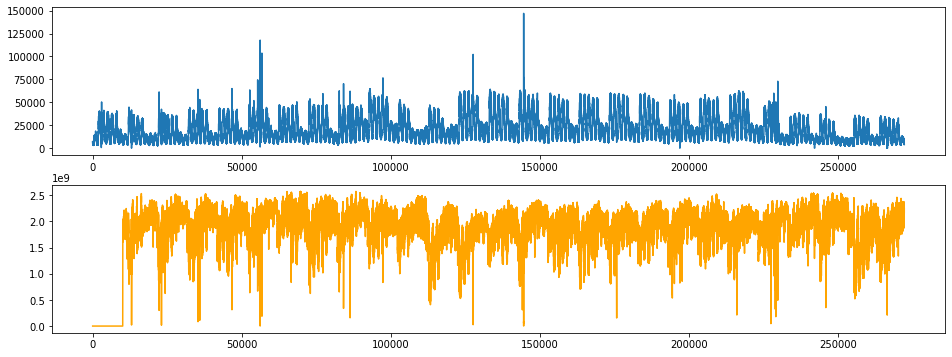

In [5]:
fig, axs = plt.subplots(2, figsize=(16,6))
axs[0].plot(df_to_use["value"].values[0: ])
axs[1].plot(scores[0: ], "orange")

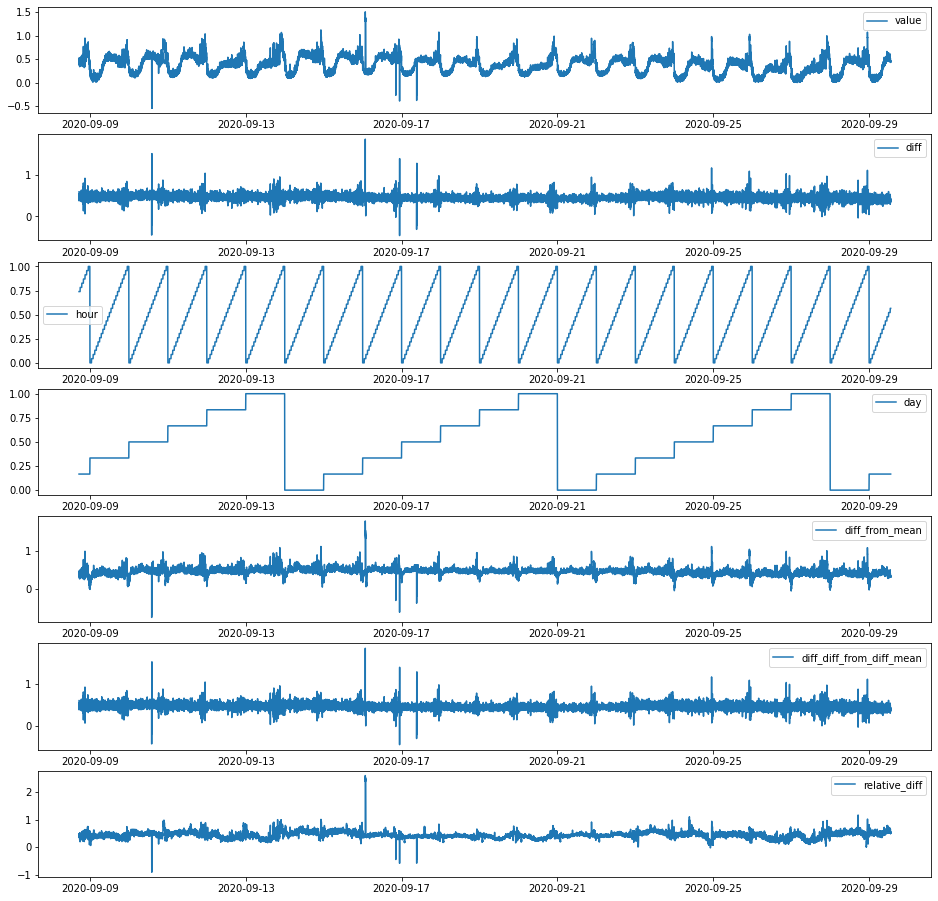

In [10]:
fig, axs = plt.subplots(len(dataset.columns), figsize=(16, 16))
start = 50000
length = 30000
for i in range(len(dataset.columns)):
    colname = dataset.columns[i]
    axs[i].plot(df_to_use["timestamp"][start: start + length], dataset[colname][start: start + length], label=colname)
    axs[i].legend()

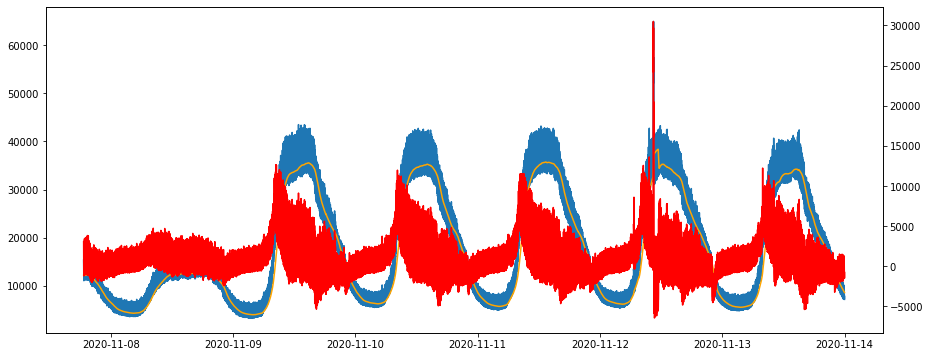

In [46]:
plt.figure(figsize=(15,6))
plt.plot(a_df["timestamp"][40000: 48960], a_df["value"][40000: 48960])
plt.plot(a_df["timestamp"][40000: 48960], a_df["value"].rolling(60).mean()[40000: 48960], 'orange')
plt.twinx().plot(a_df["timestamp"][40000: 48960], a_df["value"][40000: 48960] - a_df["value"].rolling(60).mean()[40000: 48960], 'red')

In [208]:
def create_dataset(df):
    pd.options.mode.chained_assignment = None
    d = df.copy()
    d["diff"] = d["value"].diff()
    d["hour"] = d["timestamp"].dt.hour
    d["day"] = d["timestamp"].dt.dayofweek
    d["diff_from_mean"] = d["value"] - d["value"].rolling(120).mean()
    d["diff_diff_from_diff_mean"] = d["diff"] - d["diff"].rolling(120).mean()
    d["relative_diff"] = np.nan
    
    days = []
    past_week_avg_days = []
    i = 0
    cnt = 0
    while i + 1440 < df.shape[0]:
        if cnt >= 7:
            past_week = days[-7:]
            past_week.append(days[-7])
#             past_week.append(days[-7])
#             past_week.append(days[-7])
            past_week_avg_days.append(np.average(np.vstack(past_week), axis=0))
            d["relative_diff"][i: i + 1440] = (d["value"][i: i + 1440] - past_week_avg_days[-1]) / past_week_avg_days[-1]
        days.append(d["value"].values[i: i + 1440])
        i += 1440
        cnt += 1
    
    
    pd.options.mode.chained_assignment = "warn"
    return d.dropna()

In [209]:
a_set = create_dataset(a_df)
for colname in a_set.columns:
    print("a", colname, a_set[colname].min(), a_set[colname].max())
b_set = create_dataset(b_df)
for colname in b_set.columns:
    print("b", colname, b_set[colname].min(), b_set[colname].max())
c_set = create_dataset(c_df)
for colname in c_set.columns:
    print("c", colname, c_set[colname].min(), c_set[colname].max())

a timestamp 2020-10-18 00:00:00 2021-04-16 23:59:00
a value 0.0 146944.0
a diff -65340.0 116475.0
a hour 0 23
a day 0 6
a diff_from_mean -33302.2 123145.91666666667
a diff_diff_from_diff_mean -65653.81666666667 115614.45
a relative_diff -1.0 15.782740375193743
b timestamp 2020-08-12 00:00:00 2021-02-08 23:59:00
b value 0.0 665174.0
b diff -203664.0 270712.0
b hour 0 23
b day 0 6
b diff_from_mean -218559.81666666668 294406.625
b diff_diff_from_diff_mean -204118.43333333332 269226.7916666667
b relative_diff -1.0 2.178877258831242
c timestamp 2020-07-15 00:00:00 2021-01-11 23:59:00
c value 0.0 647256.0
c diff -376320.0 453269.0
c hour 0 23
c day 0 6
c diff_from_mean -157201.65 574543.425
c diff_diff_from_diff_mean -375947.4 449091.1666666667
c relative_diff -1.0 36.06293288750896


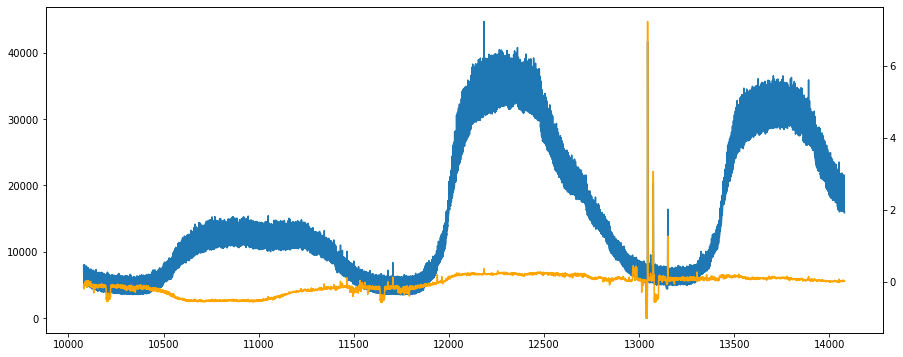

In [214]:
plt.figure(figsize=(15,6))
plt.plot(a_set["value"][:4000])
plt.twinx().plot(a_set["relative_diff"][:4000], 'orange')

In [151]:
data = b_set[["value", "hour", "diff_from_mean"]]
val_min = 0
val_max = 500000
data["value"] = (data["value"] - val_min) / val_max
diff_min = -1 * (val_max - val_min) / 2
diff_max = (val_max - val_min) / 2
# data["diff"] = (data["diff"] - diff_min) / diff_max
data["hour"] = (data["hour"].floordiv(3)) / 8
data["diff_from_mean"] = (data["diff_from_mean"] - diff_min) / diff_max

X = data.values

final_scores = StreamingHSTrees(X, 1440 * 7, 50, 10)

<ipython-input-151-5b3d178f4614>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["value"] = (data["value"] - val_min) / val_max
<ipython-input-151-5b3d178f4614>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["hour"] = (data["hour"].floordiv(4)) / 6
<ipython-input-151-5b3d178f4614>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

dimensionality is  3
10080 steps done, first masses recorded
Reset tree 10080 20159
Reset tree 10080 30239
Reset tree 10080 40319
Reset tree 10080 50399
Reset tree 10080 60479
Reset tree 10080 70559
Reset tree 10080 80639
Reset tree 10080 90719
Reset tree 10080 100799
Reset tree 10080 110879
Reset tree 10080 120959
Reset tree 10080 131039
Reset tree 10080 141119
Reset tree 10080 151199
Reset tree 10080 161279
Reset tree 10080 171359
Reset tree 10080 181439
Reset tree 10080 191519
Reset tree 10080 201599
Reset tree 10080 211679
Reset tree 10080 221759
Reset tree 10080 231839
Reset tree 10080 241919
Reset tree 10080 251999
Reset tree 10080 262079


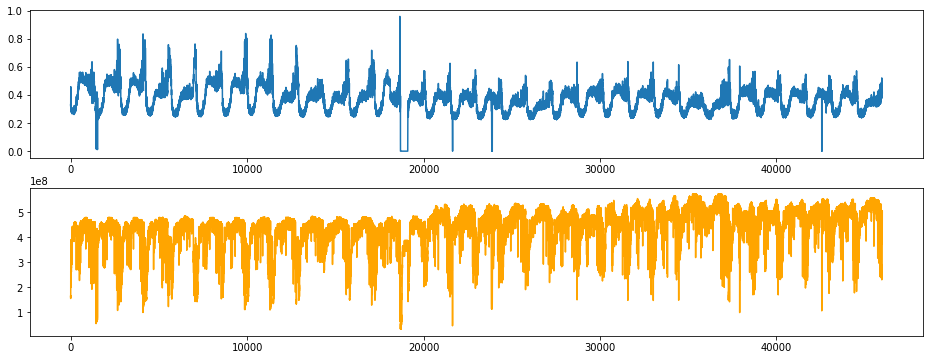

In [152]:
fig, axs = plt.subplots(2, figsize=(16,6))
axs[0].plot(data["value"].values[10000: 56000])
axs[1].plot(final_scores[10000: 56000], "orange")

In [42]:
b_set

,timestamp,value,diff,hour,day,diff_from_mean,diff_diff_from_diff_mean
120,2020-08-05 02:00:00,151253.0,6630.0,2,2,-5141.608333,7103.383333
121,2020-08-05 02:01:00,146656.0,-4597.0,2,2,-9432.091667,-4290.483333
122,2020-08-05 02:02:00,150950.0,4294.0,2,2,-4913.250000,4518.841667
123,2020-08-05 02:03:00,140740.0,-10210.0,2,2,-14803.158333,-9889.908333
124,2020-08-05 02:04:00,146667.0,5927.0,2,2,-8737.700000,6065.458333
...,...,...,...,...,...,...,...
272155,2021-02-09 23:55:00,0.0,0.0,23,1,0.000000,0.000000
272156,2021-02-09 23:56:00,0.0,0.0,23,1,0.000000,0.000000
272157,2021-02-09 23:57:00,0.0,0.0,23,1,0.000000,0.000000
272158,2021-02-09 23:58:00,0.0,0.0,23,1,0.000000,0.000000


In [66]:
b_df

,timestamp,value
0,2020-08-05 00:00:00,208059.0
1,2020-08-05 00:01:00,183438.0
2,2020-08-05 00:02:00,177931.0
3,2020-08-05 00:03:00,179151.0
4,2020-08-05 00:04:00,163282.0
...,...,...
272155,2021-02-09 23:55:00,0.0
272156,2021-02-09 23:56:00,0.0
272157,2021-02-09 23:57:00,0.0
272158,2021-02-09 23:58:00,0.0


188 181 188


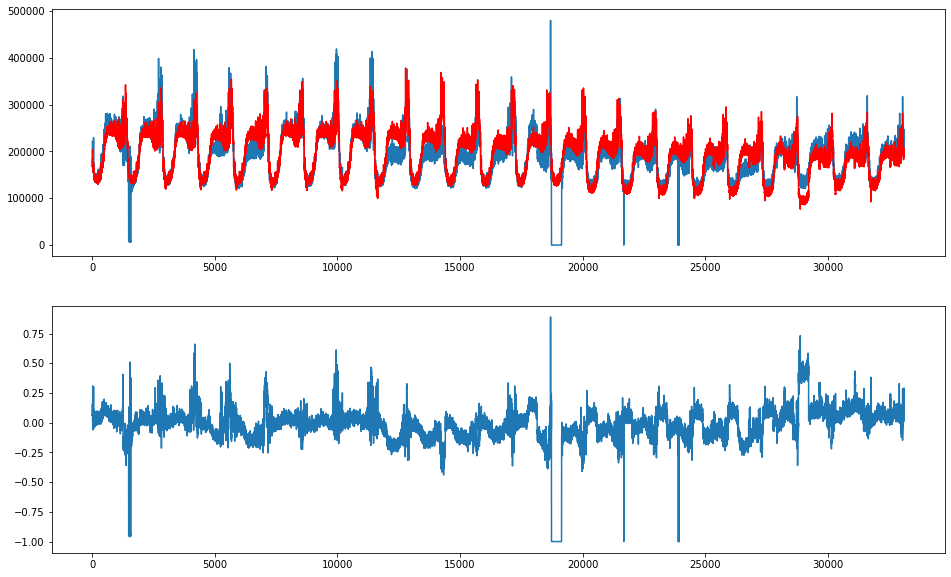

In [159]:
fig, axs = plt.subplots(2, figsize=(16,10))
axs[0].plot(np.hstack(days[7: 30]))
axs[0].plot(np.hstack(past_week_avg_days[0: 23]), "red")
axs[1].plot((np.hstack(days[7: 30]) - np.hstack(past_week_avg_days[0: 23])) / np.hstack(past_week_avg_days[0: 23]))


In [78]:
b_df["value"][1440: 1440 +1440]

1440    198398.0
1441    169190.0
1442    175116.0
1443    169196.0
1444    161188.0
          ...   
2875    211256.0
2876    214892.0
2877    229705.0
2878    215475.0
2879    222528.0
Name: value, Length: 1440, dtype: float64

In [80]:
buff+ b_df["value"][1440: 1440 + 1440]

0       208059.0
1       183438.0
2       177931.0
3       179151.0
4       163282.0
          ...   
1435    214580.0
1436    229545.0
1437    238316.0
1438    215479.0
1439    214515.0
Name: value, Length: 1440, dtype: float64

188